In [2]:
from math import log
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pycbc import frame
from pycbc.filter import matched_filter
from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.conversions import eta_from_mass1_mass2

In [3]:
path_bns_noise = "/mnt/d/project_data/psd_3g/data/CE/bns_median_CE_norotation_6h/confusion_noise_CE_1_BNS_21600s.gwf"
path_bns_single = "/mnt/d/project_data/psd_3g/data/CE/bns_single_injection_CE_norotation/confusion_noise_CE_1_BNS_21600s.gwf"
path_CE_det_noise = "/mnt/d/project_data/psd_3g/data/CE/CE_6h/det_noise_CE_21600s.gwf"

single_injection = frame.read_frame(location=path_bns_single, channels='H1:LDAS-STRAIN', start_time=3600, end_time=7200)
confusion_noise = frame.read_frame(location=path_bns_noise, channels='H1:LDAS-STRAIN', start_time=3600, end_time=7200)
det_noise = frame.read_frame(location=path_CE_det_noise, channels='H1:LDAS-STRAIN', start_time=3600, end_time=7200)
total_strain = TimeSeries(confusion_noise.data + det_noise.data, delta_t=1.0/det_noise.sample_rate, epoch=det_noise.start_time)
total_strain_single = TimeSeries(single_injection.data + det_noise.data, delta_t=1.0/det_noise.sample_rate, epoch=det_noise.start_time)

# Noise-free
total_strain_noisefree = TimeSeries(confusion_noise.data, delta_t=1.0/det_noise.sample_rate, epoch=det_noise.start_time)

## Overlapping case

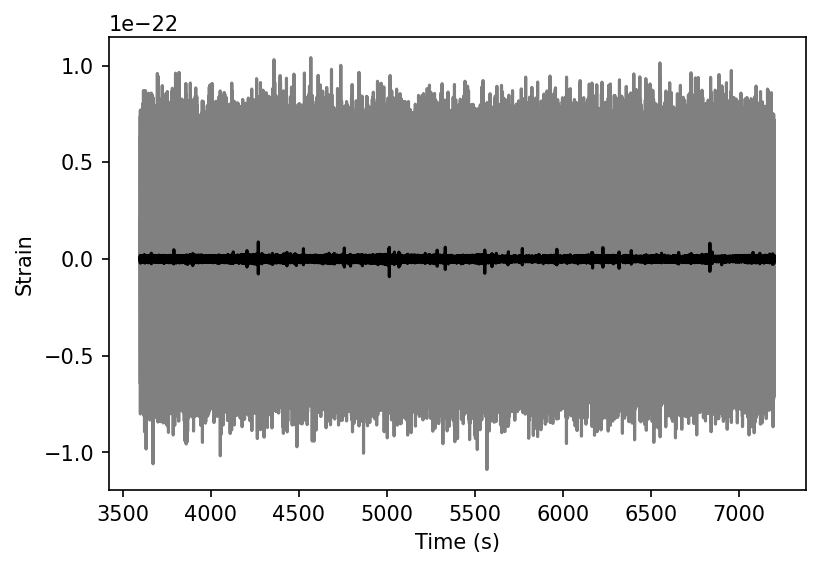

In [5]:
plt.figure(dpi=150)
plt.plot(total_strain.sample_times, total_strain, color="gray")
plt.plot(confusion_noise.sample_times, confusion_noise.data, color="black")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

## Single signal case

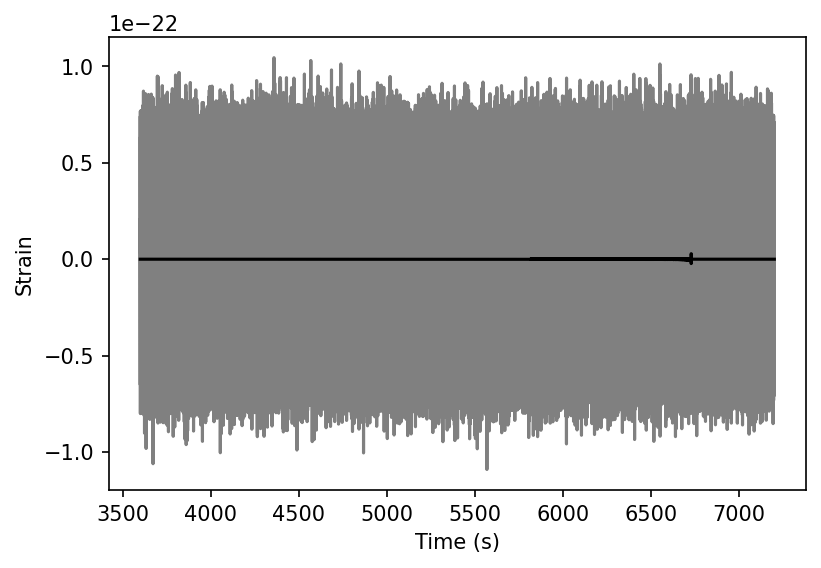

In [6]:
plt.figure(dpi=150)
plt.plot(total_strain_single.sample_times, total_strain_single, color="gray")
plt.plot(single_injection.sample_times, single_injection.data, color="black")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

In [8]:
# load det
import pandas as pd

psd_CE_det = pd.read_csv('psd_CE_det_512s_16s_5h.csv')
psd_CE_det = np.array(psd_CE_det).T

mean_psd_CE_det = np.mean(psd_CE_det[1:], axis=0)
psd = FrequencySeries(initial_array=mean_psd_CE_det, delta_f=1/16)
psd = interpolate(psd, total_strain.delta_f)

print(psd.sample_frequencies, psd)

[0.00000000e+00 2.77777778e-04 5.55555556e-04 ... 2.04799944e+03
 2.04799972e+03 2.04800000e+03] [2.72191342e-59 2.73412288e-59 2.74633235e-59 ... 1.50931672e-49
 1.49384668e-49 1.47837665e-49]


[0.00000000e+00 2.77777778e-04 5.55555556e-04 ... 2.04799944e+03
 2.04799972e+03 2.04800000e+03] [2.72191342e-59 2.73412288e-59 2.74633235e-59 ... 1.50931672e-49
 1.49384668e-49 1.47837665e-49]


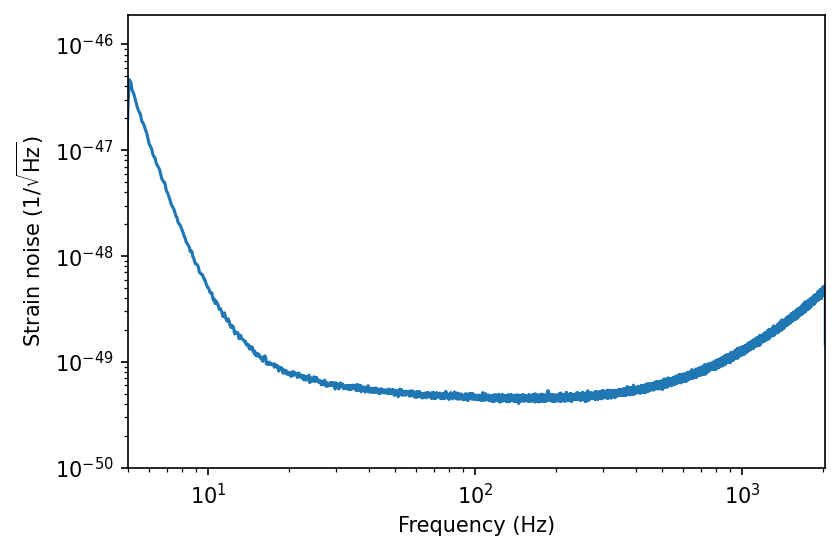

In [4]:
plt.figure(dpi=150)
plt.loglog(psd.sample_frequencies, psd.data)
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.xlabel('Frequency (Hz)')
plt.xlim(5, 2048)
plt.ylim(1*10**(-50), )
plt.show()

## Make the template

In [5]:
m1 = 4.943744690224923133
m2 = 4.994470305074671046

hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=m1, mass2=m2,
                         f_lower=5, delta_f=1./total_strain.duration)
hp.resize(len(total_strain)//2+1)

template = hp

In [6]:
def chirp_time(m_total, m_eta, f_min):
    const_Msun = 1.989e30                      # kg
    const_G = 6.67259e-11                      # m^3/kg/s^2
    const_c = 2.99792458e8                     # m/s
    const_Euler = 0.577216

    mu = (np.pi*const_G*m_total*const_Msun*f_min/const_c**3)**(1./3)

    # 3.5 PN
    chirp_t = (5/256/m_eta)*(const_G*m_total*const_Msun/const_c**3)*( \
                (mu**(-8)) +(743/252+11/3*m_eta)*mu**(-6)-32*np.pi/5*mu**(-5)+ \
                    (3058673/508032+5429/504*m_eta+617/72*m_eta**2)*mu**(-4)+ \
                        (13*m_eta/3-7729/252)*np.pi*mu**(-3)+ \
                (6848*const_Euler/105-10052469856691/23471078400+128*np.pi**2/3+ \
                    (3147553127/3048192-451*np.pi**2/12)*m_eta-15211/1728*m_eta**2+ \
                        25565/1296*m_eta**3+6848/105*log(4*mu))*mu**(-2)+ \
                            (14809/378*m_eta**2-75703/756*m_eta-15419335/127008)*np.pi*mu**(-1))
    return chirp_t

In [9]:
fmin = 5 # Hz
psd_duration = 16 # s
template_duration = chirp_time(m1+m2, eta_from_mass1_mass2(m1,m2), fmin)

snr = matched_filter(template, total_strain, psd=psd, low_frequency_cutoff=fmin)
snr = snr.crop(psd_duration+template_duration, psd_duration)

peak = np.array(abs(snr)).argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

In [8]:
print(template_duration, len(snr.sample_times)/4096)

783.8133075245322 2784.186767578125


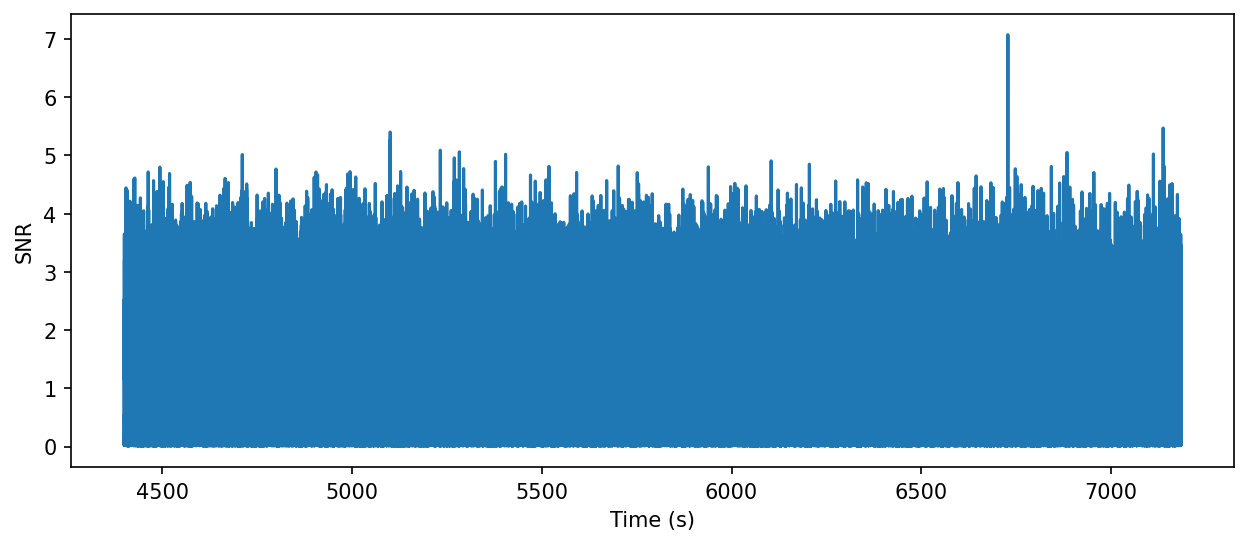

We found a signal at 6728.0485839845s with SNR 7.075165084401176


In [15]:
plt.figure(figsize=[10, 4], dpi=150)
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('SNR')
plt.xlabel('Time (s)')
plt.show()

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

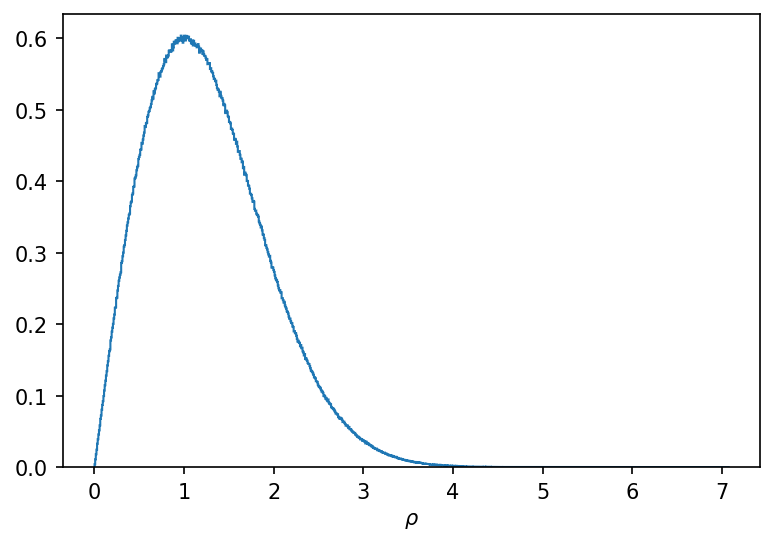

In [9]:
plt.figure(dpi=150)
plt.hist(abs(snr), bins=1000, density=True, histtype='step')
plt.xlabel(r'$\rho$')
plt.show()

## Overlapping case (noise-free)

In [10]:
snr_2 = matched_filter(template, total_strain_noisefree, psd=psd, low_frequency_cutoff=fmin)
snr_2 = snr_2.crop(psd_duration+template_duration, psd_duration)

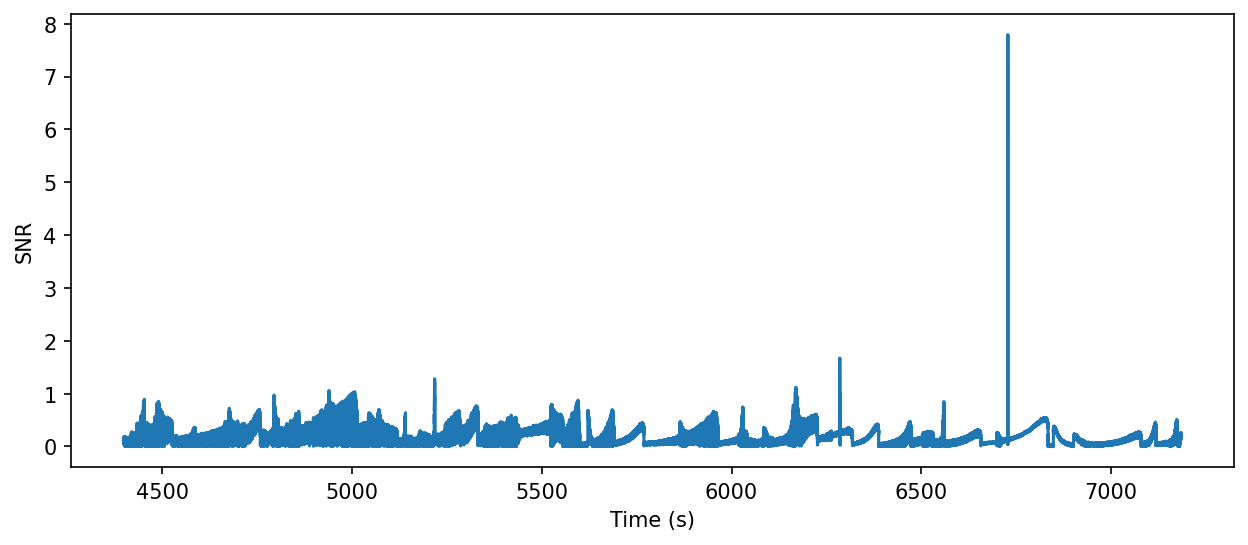

We found a signal at 6728.048339843875s with SNR 7.7919196363169325


In [20]:
plt.figure(figsize=[10, 4], dpi=150)
plt.plot(snr_2.sample_times, abs(snr_2))
plt.ylabel('SNR')
plt.xlabel('Time (s)')
plt.show()

peak = np.array(abs(snr_2)).argmax()
snrp = snr_2[peak]
time = snr_2.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

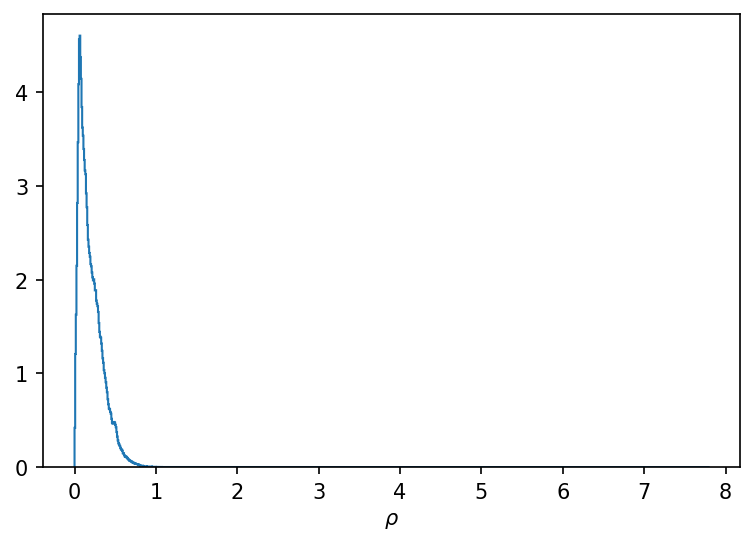

In [21]:
plt.figure(dpi=150)
plt.hist(abs(snr_2), bins=1000, density=True, histtype='step')
plt.xlabel(r'$\rho$')
plt.show()

## Single signal case

In [11]:
snr_3 = matched_filter(template, total_strain_single, psd=psd, low_frequency_cutoff=fmin)
snr_3 = snr_3.crop(psd_duration+template_duration, psd_duration)

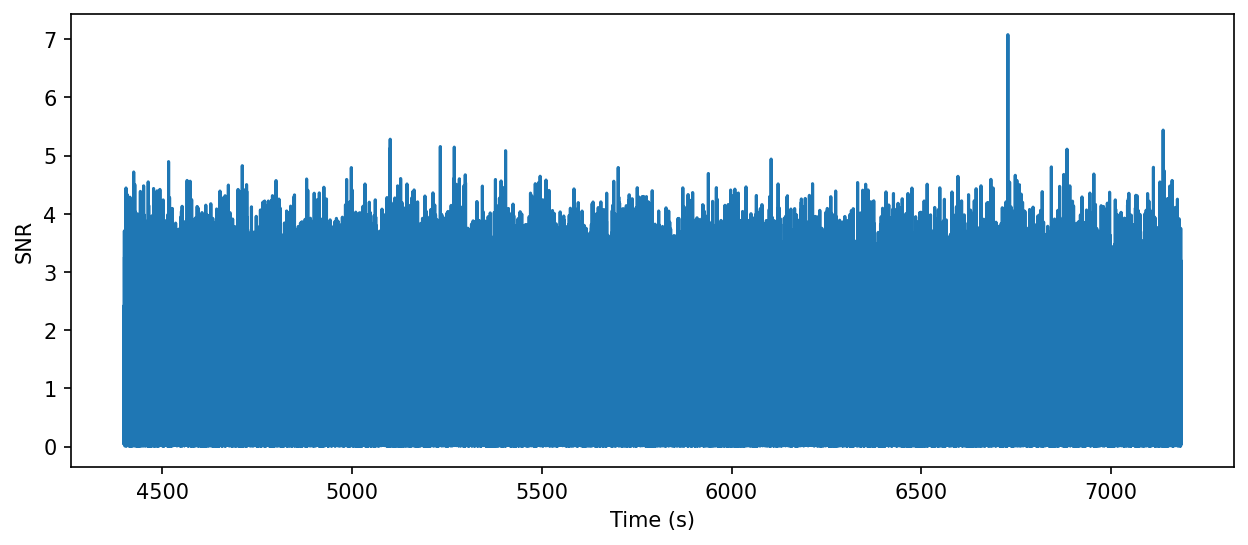

We found a signal at 6728.0485839845s with SNR 7.076214759037203


In [23]:
plt.figure(figsize=[10, 4], dpi=150)
plt.plot(snr_3.sample_times, abs(snr_3))
plt.ylabel('SNR')
plt.xlabel('Time (s)')
plt.show()

peak = np.array(abs(snr_3)).argmax()
snrp = snr_3[peak]
time = snr_3.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

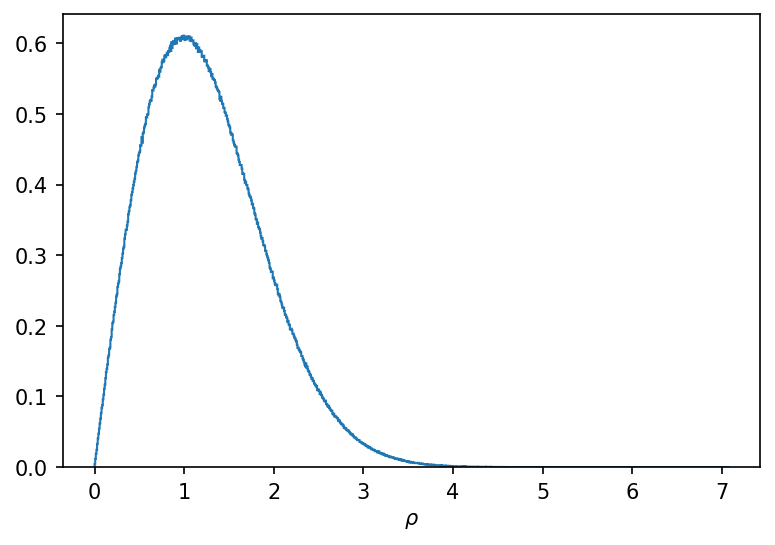

In [24]:
plt.figure(dpi=150)
plt.hist(abs(snr_3), bins=1000, density=True, histtype='step')
plt.xlabel(r'$\rho$')
plt.show()

## Single signal case (noise-free)

In [12]:
snr_4 = matched_filter(template, single_injection, psd=psd, low_frequency_cutoff=fmin)
snr_4 = snr_4.crop(psd_duration+template_duration, psd_duration)

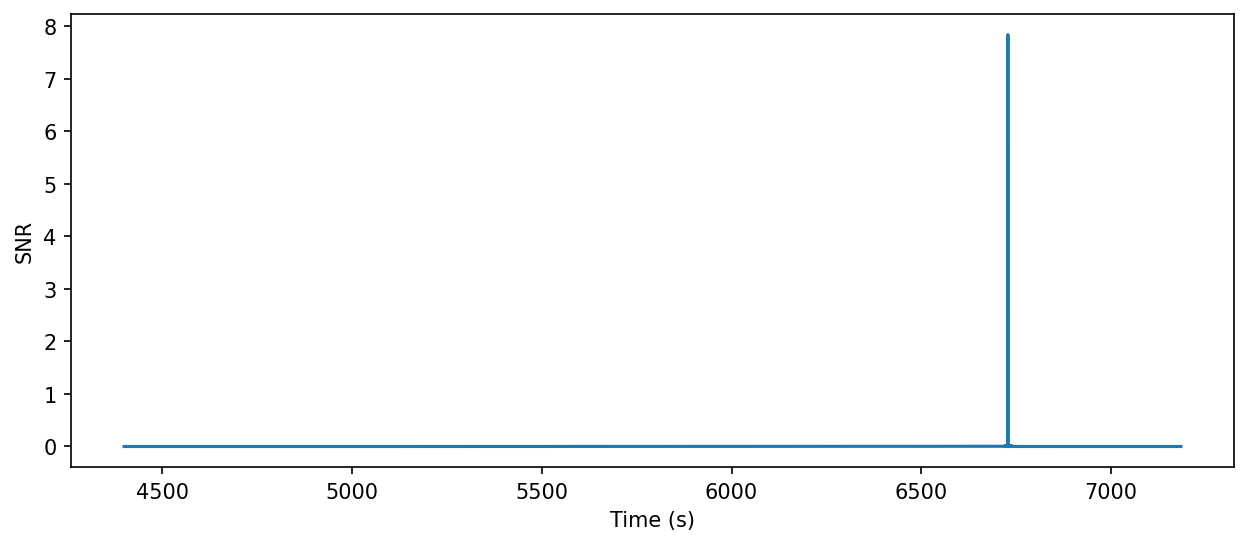

We found a signal at 6728.048339843875s with SNR 7.836844949159329


In [26]:
plt.figure(figsize=[10, 4], dpi=150)
plt.plot(snr_4.sample_times, abs(snr_4))
plt.ylabel('SNR')
plt.xlabel('Time (s)')
plt.show()

peak = np.array(abs(snr_4)).argmax()
snrp = snr_4[peak]
time = snr_4.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

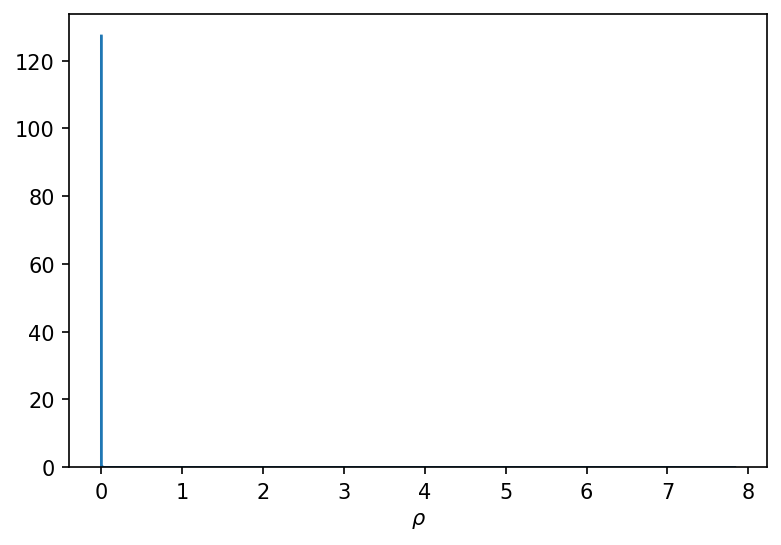

In [27]:
plt.figure(dpi=150)
plt.hist(abs(snr_4), bins=1000, density=True, histtype='step')
plt.xlabel(r'$\rho$')
plt.show()

## Plot together

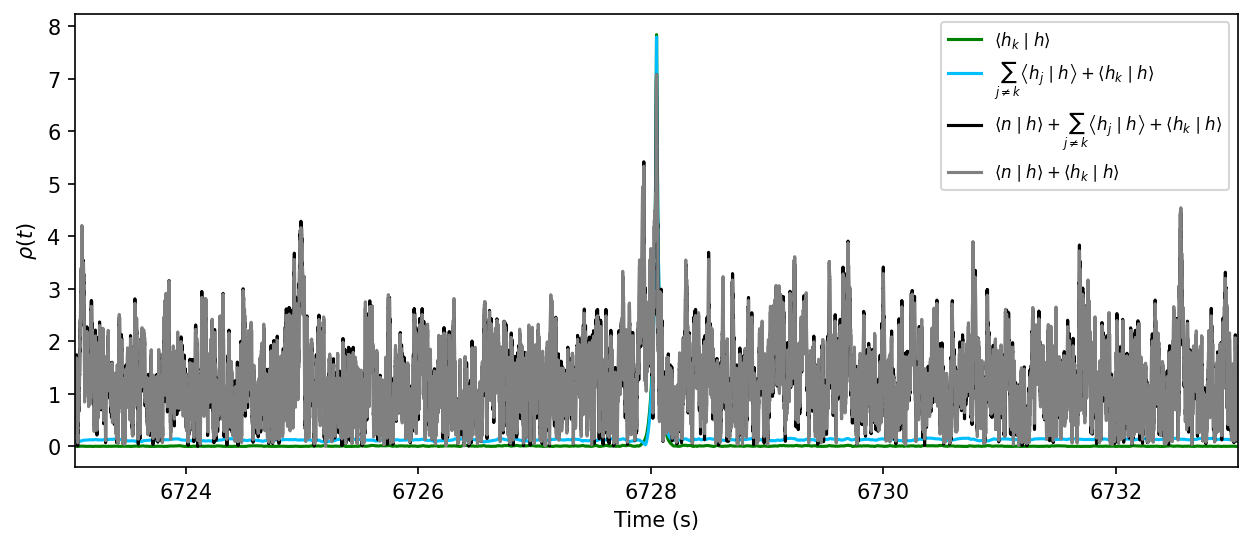

In [34]:
plt.figure(figsize=[10, 4], dpi=150)
plt.rc('legend', fontsize=8)
plt.plot(snr_4.sample_times, abs(snr_4), label=r"$\left\langle h_{k} \mid h\right\rangle$", color="green")
plt.plot(snr_2.sample_times, abs(snr_2), label=r"$\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="deepskyblue")
plt.plot(snr.sample_times, abs(snr), label=r"$\left\langle n \mid h\right\rangle+\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="black")
plt.plot(snr_3.sample_times, abs(snr_3), label=r"$\left\langle n \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="gray")
plt.xlim(time-5, time+5)
plt.ylabel(r'$\rho(t)$')
plt.xlabel('Time (s)')
plt.legend(loc="upper right")
plt.show()

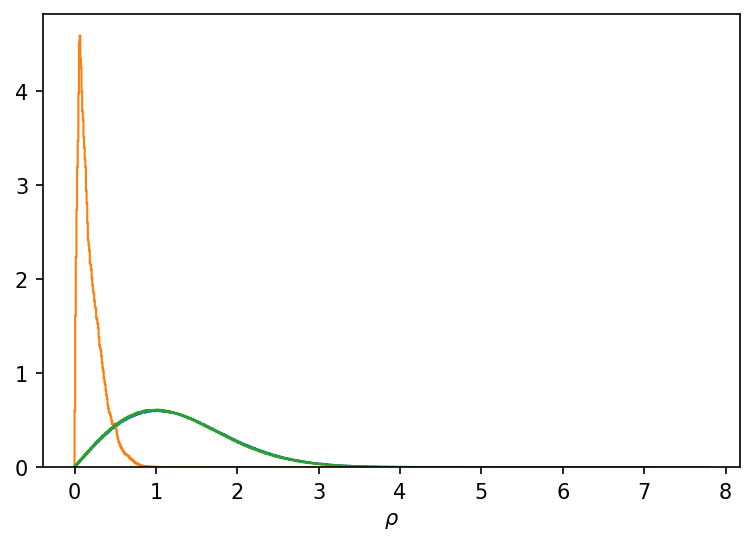

In [14]:
plt.figure(dpi=150)
plt.hist(abs(snr), bins=1000, density=True, histtype='step')
plt.hist(abs(snr_2), bins=1000, density=True, histtype='step')
plt.hist(abs(snr_3), bins=1000, density=True, histtype='step')
plt.xlabel(r'$\rho$')
plt.show()

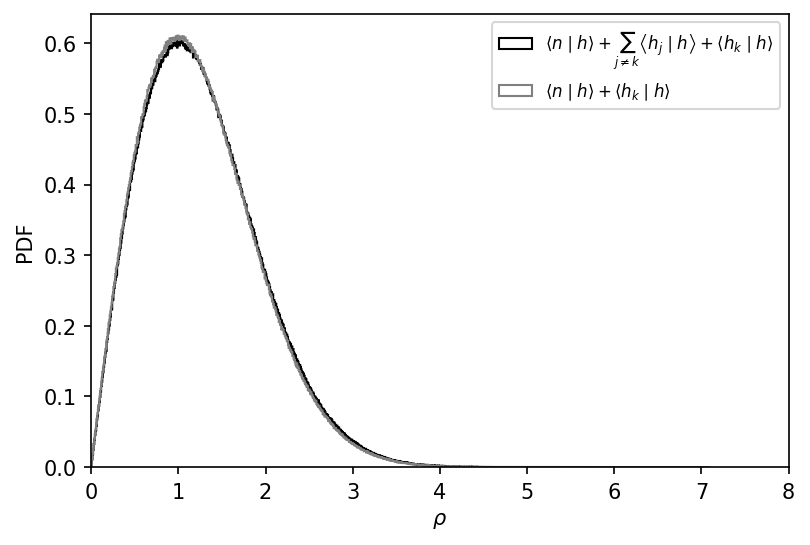

In [37]:
plt.figure(dpi=150)
plt.hist(abs(snr), bins=1000, density=True, histtype='step', label=r"$\left\langle n \mid h\right\rangle+\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="black")
# plt.hist(abs(snr_2), bins=1000, density=True, histtype='step', label=r"$\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="deepskyblue")
plt.hist(abs(snr_3), bins=1000, density=True, histtype='step', label=r"$\left\langle n \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="gray")
plt.xlim(0, 8)
plt.xlabel(r'$\rho$')
plt.ylabel("PDF")
plt.legend(loc="upper right")
plt.show()

/tmp/ipykernel_3810/1560521896.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


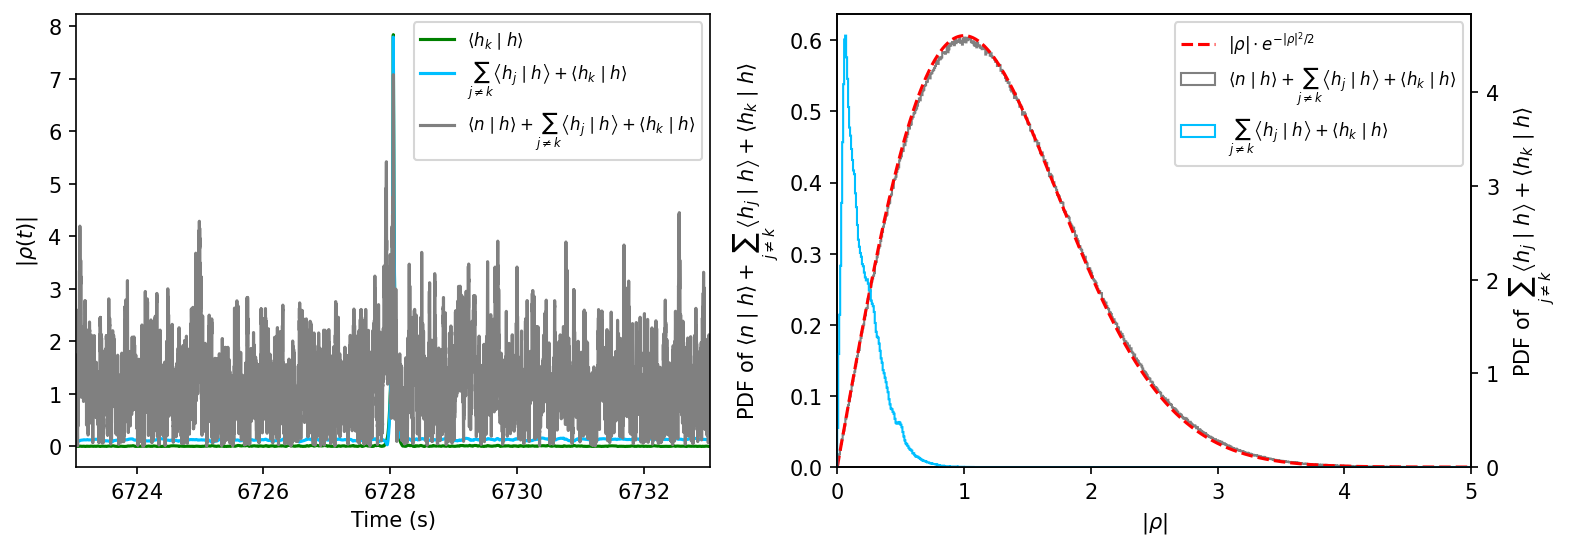

In [13]:
f = plt.figure(figsize=(12,4), dpi=150)
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(snr_4.sample_times, abs(snr_4), label=r"$\left\langle h_{k} \mid h\right\rangle$", color="green")
ax1.plot(snr_2.sample_times, abs(snr_2), label=r"$\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="deepskyblue")
ax1.plot(snr.sample_times, abs(snr), label=r"$\left\langle n \mid h\right\rangle+\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="gray")
# ax1.plot(snr_3.sample_times, abs(snr_3), label=r"$\left\langle n \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="black")
ax1.set_xlim(time-5, time+5)
ax1.set_ylabel(r'$\left| \rho(t) \right|$')
ax1.set_xlabel('Time (s)')
ax1.legend(loc="upper right", fontsize=8)

def rayleigh_dist(rho):
    return rho*np.e**(-0.5*rho**2)

rayleigh = rayleigh_dist(np.linspace(0, 5, 1000))

ax2.plot(np.linspace(0, 5, 1000), rayleigh, label=r"$\left| \rho \right| \cdot e^{-\left| \rho \right|^{2} / 2}$", linestyle="dashed", color="red")
ax2.hist(abs(snr), bins=1000, density=True, histtype='step', label=r"$\left\langle n \mid h\right\rangle+\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="gray")
ax3 = ax2.twinx()
ax3.hist(abs(snr_2), bins=1000, density=True, histtype='step', label=r"$\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="deepskyblue")
# ax2.hist(abs(snr_3), bins=1000, density=True, histtype='step', label=r"$\left\langle n \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$", color="black")
ax2.set_xlim(0, 5)
ax2.set_xlabel(r'$\left| \rho \right|$')
ax2.set_ylabel(r"PDF of $\left\langle n \mid h\right\rangle+\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$")
ax3.set_ylabel(r"PDF of $\sum_{j \neq k}\left\langle h_{j} \mid h\right\rangle+\left\langle h_{k} \mid h\right\rangle$")

line_1, label_1 = ax2.get_legend_handles_labels()
line_2, label_2 = ax3.get_legend_handles_labels()
ax2.legend(line_1+line_2, label_1+label_2, loc="upper right", fontsize=8)

f.savefig('snr_timeseries_rayleigh_CE.pdf', dpi=500)
f.show()